# Feedback figures for Ford et al. (2025)

This notebook contains the code required to reproduce Figs. 5 and 6 in Ford et al. (2025). The feedbacks analysis using radiative kernels is computed in a separate notebook, which outputs the file `OHUTCR-feedbacks.nc` that is loaded into this notebook. 

The APRP code based on: 

Mark Zelinka. (2023). mzelinka/aprp: Aug 1, 2023 Release (v3.0). Zenodo. https://doi.org/10.5281/zenodo.8206763

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob, os
import s3fs
import fsspec
from scipy.stats import pearsonr

In [2]:
def global_average(data, lon=True):
    weights = np.cos(np.deg2rad(data.lat))
    data_weighted = data.weighted(weights)
    if lon == True: 
        return data_weighted.mean(dim=['lat', 'lon'], skipna=True)
    else: return data_weighted.mean(dim='lat', skipna=True)

def smid(da):
    return global_average(da.where((da.lat > -60) & (da.lat < -30)))

def esmid(da):
    return global_average(da.where((da.lat > -50) & (da.lat < -30)))

def psmid(da):
    return global_average(da.where((da.lat > -60) & (da.lat < -45)))

In [3]:
def plot_trend(ax, x, y):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xrange = np.arange(-10, 10, 1)
    z = np.polyfit(x, y, 1)
    m, b = z[0], z[1]
    ax.plot(xrange, m*xrange+b, color='k', linestyle=':', alpha=0.5)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

In [4]:
def albedo(c, a_clr, a_oc, mu_clr, mu_cld, ga_clr, ga_cld):
    mu_oc = mu_clr*mu_cld # Eq. 14
    ga_oc = 1 - (1 - ga_clr)*(1 - ga_cld) # Eq. 13
    A_clr = (mu_clr*ga_clr) + ((mu_clr*a_clr*(1 - ga_clr)**2)/(1 - (a_clr*ga_clr))) # Eq. 7
    A_oc = (mu_oc*ga_oc) + ((mu_oc*a_oc*(1 - ga_oc)**2)/(1 - (a_oc*ga_oc))) # Eq. 7
    A = (1 - c)*A_clr + c*A_oc # Eq. 15
    return A

In [5]:
def parameters(SWupsfccs, SWdnsfccs, SWdn, SWupcs, SWupsfcoc, SWdnsfcoc, SWupoc):
    # clear sky parameters
    a_clr = SWupsfccs/SWdnsfccs # albedo
    Q = SWdnsfccs/SWdn # ratio of incident sfc flux to TOA insolation
    mu_clr = SWupcs/SWdn + Q*(1 - a_clr) # Eq. 9
    ga_clr = (mu_clr - Q)/(mu_clr - a_clr*Q) # Eq. 10

    # overcast parameters
    a_oc = SWupsfcoc/SWdnsfcoc # albedo
    Q = SWdnsfcoc/SWdn # ratio of incident sfc flux to TOA insolation
    mu_oc = SWupoc/SWdn + Q*(1 - a_oc) # Eq. 9
    ga_oc = (mu_oc - Q)/(mu_oc - a_oc*Q) # Eq. 10

    # cloud parameters
    mu_cld = mu_oc/mu_clr  # Eq. 14 sometimes this is greater than 1??
    ga_cld = (ga_oc - 1)/(1 - ga_clr) + 1  # Eq. 13

    return (a_clr, mu_clr, ga_clr, a_oc, mu_cld, ga_cld) 

## Load in data

In [6]:
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/OHUTCR-data'
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))
pattern = f's3://{path}/*.nc'
files = sorted(fs.glob(pattern))
fileset = [fs.open(file) for file in files]
fileset

[<File-like object S3FileSystem, pythia/OHUTCR-data/CESM1-CAM5_CO2.cam.h0.mean.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/CESM1-CAM5_ctrl.cam.h0.mean.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/OHUTCR-feedbacks.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/cmip5em-tcr-mean-output.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/cold4-model-tcr-mean-output.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/pop_frc.b.e11.B1850C5CN.f19_g16.130429.nc>,
 <File-like object S3FileSystem, pythia/OHUTCR-data/warm13-model-tcr-mean-output.nc>]

In [7]:
pert = xr.open_dataset(fileset[6]).drop_sel(model='GFDL-ESM2G')
ctrl = xr.open_dataset(fileset[1]).isel(time=0).drop('time')
co2 = xr.open_dataset(fileset[0]).isel(time=0).drop('time')
cmqf = xr.open_dataset(fileset[3])

In [8]:
gmst = global_average(pert.TREFHT)
gmst_cm = global_average(cmqf.TREFHT)
gmst_co2 = global_average(co2.TREFHT)

In [9]:
tcr = global_average(pert.TREFHT - ctrl.TREFHT)
tcr_cm = global_average(cmqf.TREFHT - ctrl.TREFHT)
ecs = global_average(co2.TREFHT - ctrl.TREFHT)

Load in kernel feedbacks, which were calculated in a separate notebook:

In [10]:
fbs = xr.open_dataset(fileset[2])

## Do APRP analysis

Using the CMIP naming convention, subscripting the control 1 and perturbation 2:

In [11]:
def aprp(ctrl, pert):
    clt1, clt2 = ctrl.CLDTOT, pert.CLDTOT
    rsdt1, rsdt2 = ctrl.SOLIN, pert.SOLIN
    rsut1, rsut2 = ctrl.FSUTOA, pert.FSUTOA
    rsutcs1, rsutcs2 = (-ctrl.FSNTOAC + ctrl.SOLIN), (-pert.FSNTOAC + pert.SOLIN)
    rsds1, rsds2 = ctrl.FSDS, pert.FSDS
    rsus1, rsus2 = (-ctrl.FSNS + ctrl.FSDS), (-pert.FSNS + pert.FSDS)
    rsdscs1, rsdscs2 = ctrl.FSDSC, pert.FSDSC
    rsuscs1, rsuscs2 = (-ctrl.FSNSC + ctrl.FSDSC), (-pert.FSNSC + pert.FSDSC)

    rsutoc1 = (1/clt1)*(rsut1 - (1 - clt1)*rsutcs1)
    rsdsoc1 = (1/clt1)*(rsds1 - (1 - clt1)*rsdscs1)
    rsusoc1 = (1/clt1)*(rsus1 - (1 - clt1)*rsuscs1)
    rsutoc2 = (1/clt2)*(rsut2 - (1 - clt2)*rsutcs2)
    rsdsoc2 = (1/clt2)*(rsds2 - (1 - clt2)*rsdscs2)
    rsusoc2 = (1/clt2)*(rsus2 - (1 - clt2)*rsuscs2)

    rsdsoc1 = xr.where(rsdsoc1 > rsds1, np.nan, rsdsoc1)   
    rsusoc1 = xr.where(rsusoc1 > rsus1, np.nan, rsusoc1)
    rsutoc1 = xr.where(rsutoc1 < 0, np.nan, rsutoc1)
    rsdsoc1 = xr.where(rsdsoc1 < 0, np.nan, rsdsoc1)
    rsusoc1 = xr.where(rsusoc1 < 0, np.nan, rsusoc1)

    rsdsoc2 = xr.where(rsdsoc2 > rsds2, np.nan, rsdsoc2)
    rsusoc2 = xr.where(rsusoc2 > rsus2, np.nan, rsusoc2)
    rsutoc2 = xr.where(rsutoc2 < 0, np.nan, rsutoc2)
    rsdsoc2 = xr.where(rsdsoc2 < 0, np.nan, rsdsoc2)
    rsusoc2 = xr.where(rsusoc2 < 0, np.nan, rsusoc2) 

    a_clr1, mu_clr1, ga_clr1, a_oc1, mu_cld1, ga_cld1 = parameters(rsuscs1, rsdscs1, rsdt1, rsutcs1, rsusoc1, rsdsoc1, rsutoc1) # control
    a_clr2, mu_clr2, ga_clr2, a_oc2, mu_cld2, ga_cld2 = parameters(rsuscs2, rsdscs2, rsdt2, rsutcs2, rsusoc2, rsdsoc2, rsutoc2) # perturbed

    A_1 = albedo(clt1, a_clr1, a_oc1, mu_clr1, mu_cld1, ga_clr1, ga_cld1)
    A_2 = albedo(clt2, a_clr2, a_oc2, mu_clr2, mu_cld2, ga_clr2, ga_cld2)

    # Forward PRP calculation:
    dA_amt_cld_fwd =     albedo(clt2, a_clr1, a_oc1, mu_clr1, mu_cld1, ga_clr1, ga_cld1) - A_1 # 16b.3
    dA_a_clr_fwd =       albedo(clt1, a_clr2, a_oc1, mu_clr1, mu_cld1, ga_clr1, ga_cld1) - A_1 # 16a.1
    dA_a_oc_fwd =        albedo(clt1, a_clr1, a_oc2, mu_clr1, mu_cld1, ga_clr1, ga_cld1) - A_1 # 16a.2
    dA_abs_noncld_fwd =  albedo(clt1, a_clr1, a_oc1, mu_clr2, mu_cld1, ga_clr1, ga_cld1) - A_1 # 16c.1
    dA_abs_cld_fwd =     albedo(clt1, a_clr1, a_oc1, mu_clr1, mu_cld2, ga_clr1, ga_cld1) - A_1 # 16b.1
    dA_scat_noncld_fwd = albedo(clt1, a_clr1, a_oc1, mu_clr1, mu_cld1, ga_clr2, ga_cld1) - A_1 # 16c.2
    dA_scat_cld_fwd =    albedo(clt1, a_clr1, a_oc1, mu_clr1, mu_cld1, ga_clr1, ga_cld2) - A_1 # 16b.2

    # Backward PRP calculation:
    dA_amt_cld_bwd =     A_2 - albedo(clt1, a_clr2, a_oc2, mu_clr2, mu_cld2, ga_clr2, ga_cld2)
    dA_a_clr_bwd =       A_2 - albedo(clt2, a_clr1, a_oc2, mu_clr2, mu_cld2, ga_clr2, ga_cld2)
    dA_a_oc_bwd =        A_2 - albedo(clt2, a_clr2, a_oc1, mu_clr2, mu_cld2, ga_clr2, ga_cld2)
    dA_abs_noncld_bwd =  A_2 - albedo(clt2, a_clr2, a_oc2, mu_clr1, mu_cld2, ga_clr2, ga_cld2)
    dA_abs_cld_bwd =     A_2 - albedo(clt2, a_clr2, a_oc2, mu_clr2, mu_cld1, ga_clr2, ga_cld2)
    dA_scat_noncld_bwd = A_2 - albedo(clt2, a_clr2, a_oc2, mu_clr2, mu_cld2, ga_clr1, ga_cld2)
    dA_scat_cld_bwd =    A_2 - albedo(clt2, a_clr2, a_oc2, mu_clr2, mu_cld2, ga_clr2, ga_cld1)

    dA_amt_cld =     0.5*(dA_amt_cld_fwd + dA_amt_cld_bwd)
    dA_a_clr =       0.5*(dA_a_clr_fwd + dA_a_clr_bwd) 
    dA_a_oc =        0.5*(dA_a_oc_fwd + dA_a_oc_bwd)
    dA_abs_noncld =  0.5*(dA_abs_noncld_fwd + dA_abs_noncld_bwd)
    dA_abs_cld =     0.5*(dA_abs_cld_fwd + dA_abs_cld_bwd)
    dA_scat_noncld = 0.5*(dA_scat_noncld_fwd + dA_scat_noncld_bwd)
    dA_scat_cld =    0.5*(dA_scat_cld_fwd + dA_scat_cld_bwd)        
    RSDT = 0.5*(rsdt1 + rsdt2)

    # if the cld fraction is less than 2%, set fields to be zero
    dA_amt_cld = xr.where(clt1 < 0.02, 0., dA_amt_cld)
    dA_amt_cld = xr.where(clt2 < 0.02, 0., dA_amt_cld)
    dA_a_oc = xr.where(clt1 < 0.02, 0., dA_a_oc)
    dA_a_oc = xr.where(clt2 < 0.02, 0., dA_a_oc)
    dA_abs_cld = xr.where(clt1 < 0.02, 0., dA_abs_cld)
    dA_abs_cld = xr.where(clt2 < 0.02, 0., dA_abs_cld)
    dA_scat_cld = xr.where(clt1 < 0.02, 0., dA_scat_cld)
    dA_scat_cld = xr.where(clt2 < 0.02, 0., dA_scat_cld)

    dA_a = dA_a_clr + dA_a_oc
    dA_cld = dA_abs_cld + dA_scat_cld + dA_amt_cld
    dA_noncld = dA_abs_noncld + dA_scat_noncld

    ## TOA SW Anomalies due to Surface Albedo Anomalies
    sfc_alb = -dA_a*RSDT
    sfc_alb_clr = -dA_a_clr*RSDT   
    sfc_alb_oc = -dA_a_oc*RSDT

    ## TOA SW Anomalies due to Cloud Anomalies
    cld = -dA_cld*RSDT
    cld_amt = -dA_amt_cld*RSDT    
    cld_sca = -dA_scat_cld*RSDT
    cld_abs = -dA_abs_cld*RSDT

    ## TOA SW Anomalies due to Non-cloud Anomalies
    noncld = -dA_noncld*RSDT
    noncld_sca = -dA_scat_noncld*RSDT  
    noncld_abs = -dA_abs_noncld*RSDT

    return xr.merge([sfc_alb.to_dataset(name='sfc_alb'), sfc_alb_clr.to_dataset(name='sfc_alb_clr'), sfc_alb_oc.to_dataset(name='sfc_alb_oc'),
             cld.to_dataset(name='cld'), cld_amt.to_dataset(name='cld_amt'), cld_sca.to_dataset(name='cld_sca'), cld_abs.to_dataset(name='cld_abs'),
             noncld.to_dataset(name='noncld'), noncld_sca.to_dataset(name='noncld_sca'), noncld_abs.to_dataset(name='noncld_abs')])

In [12]:
aprp_ens = aprp(ctrl, pert)
aprp_cm = aprp(ctrl, cmqf)
aprp_co2 = aprp(ctrl, co2)

## Figure 5: Global-mean feedbacks

In [13]:
gm_fbs = global_average(fbs)
ens12_gm_fbs = gm_fbs.drop_sel(model=['2xCO2-only', 'CMIP5-EM'])
copy_ens12_gm_fbs = ens12_gm_fbs

In [14]:
gm_cld = global_average(aprp_ens.cld/tcr)
gm_cld_amt = global_average(aprp_ens.cld_amt/tcr)
gm_cld_sca = global_average(aprp_ens.cld_sca/tcr)
gm_cld_abs = global_average(aprp_ens.cld_abs/tcr)

gm_cld_cm = global_average(aprp_cm.cld/tcr_cm)
gm_cld_amt_cm = global_average(aprp_cm.cld_amt/tcr_cm)
gm_cld_sca_cm = global_average(aprp_cm.cld_sca/tcr_cm)
gm_cld_abs_cm = global_average(aprp_cm.cld_abs/tcr_cm)

gm_cld_co2 = global_average(aprp_co2.cld/ecs)
gm_cld_amt_co2 = global_average(aprp_co2.cld_amt/ecs)
gm_cld_sca_co2 = global_average(aprp_co2.cld_sca/ecs)
gm_cld_abs_co2 = global_average(aprp_co2.cld_abs/ecs)

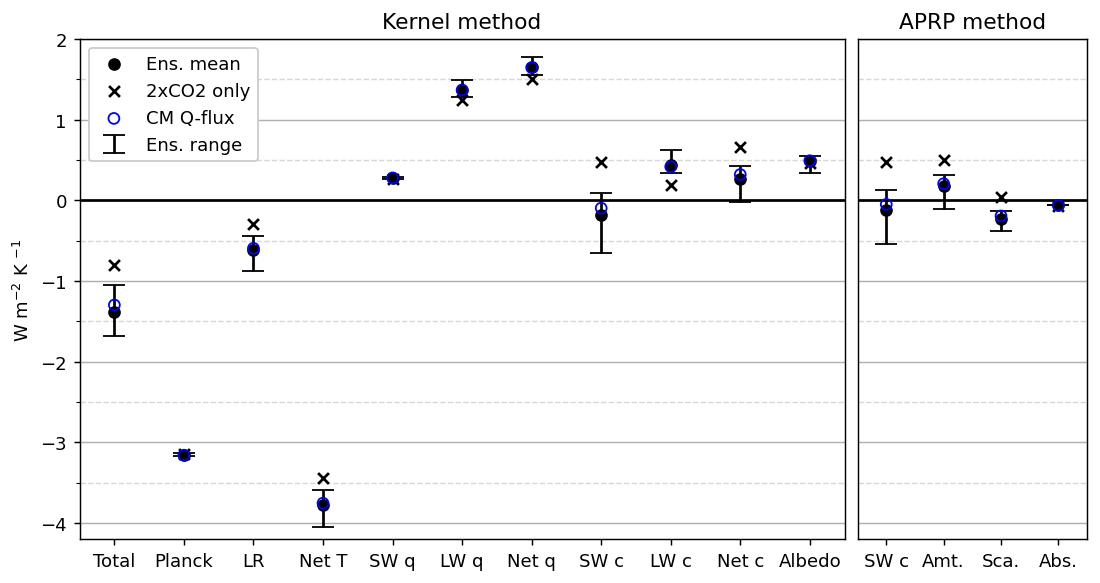

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=130)

x = np.arange(0, 17)
ax.plot(x, 0*x, 'k')

for i, key in enumerate(fbs.data_vars):
    if i == 0:
        plt.scatter(i+1, ens12_gm_fbs[key].mean(), color='k', zorder=2, label='Ens. mean')
        plt.errorbar(i+1, ens12_gm_fbs[key].mean(), 
                     yerr=[[ens12_gm_fbs[key].mean() - ens12_gm_fbs[key].min()], [ens12_gm_fbs[key].max() - ens12_gm_fbs[key].mean()]], 
                     color='k', fmt='none', capsize=6, zorder=2, label='Ens. range')
        plt.scatter(i+1, gm_fbs.sel(model='2xCO2-only')[key], marker='x', color='k', zorder=3, label='2xCO2 only')
        plt.scatter(i+1, gm_fbs.sel(model='CMIP5-EM')[key], edgecolor='b', facecolor='none', zorder=3, label='CM Q-flux')
        
    else:
        plt.scatter(i+1, ens12_gm_fbs[key].mean(), color='k', zorder=2)
        plt.errorbar(i+1, ens12_gm_fbs[key].mean(), 
                     yerr=[[ens12_gm_fbs[key].mean() - ens12_gm_fbs[key].min()], [ens12_gm_fbs[key].max() - ens12_gm_fbs[key].mean()]], 
                     color='k', fmt='none', capsize=6, zorder=2)
        plt.scatter(i+1, gm_fbs.sel(model='2xCO2-only')[key], marker='x', color='k', zorder=3)
        plt.scatter(i+1, gm_fbs.sel(model='CMIP5-EM')[key], edgecolor='b', facecolor='none', zorder=3)

divider = make_axes_locatable(ax)
ax2 = divider.new_horizontal(size="30%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax2)
ax2.set_yticklabels([])
ax2.yaxis.set_ticks_position('none')
ax2.plot(x, 0*x, 'k')

plt.scatter(1, gm_cld.mean(), color='k', zorder=2)
plt.errorbar(1, gm_cld.mean(), 
             yerr=[[gm_cld.mean() - gm_cld.min()], [gm_cld.max() - gm_cld.mean()]], 
             color='k', fmt='none', capsize=6, zorder=2)
plt.scatter(1, gm_cld_co2, marker='x', color='k', zorder=3)
plt.scatter(1, gm_cld_cm, edgecolor='b', facecolor='none', zorder=3)

plt.scatter(2, gm_cld_amt.mean(), color='k', zorder=2)
plt.errorbar(2, gm_cld_amt.mean(), 
             yerr=[[gm_cld_amt.mean() - gm_cld_amt.min()], [gm_cld_amt.max() - gm_cld_amt.mean()]], 
             color='k', fmt='none', capsize=6, zorder=2)
plt.scatter(2, gm_cld_amt_co2, marker='x', color='k', zorder=3)
plt.scatter(2, gm_cld_amt_cm, edgecolor='b', facecolor='none', zorder=3)

plt.scatter(3, gm_cld_sca.mean(), color='k', zorder=2)
plt.errorbar(3, gm_cld_sca.mean(), 
             yerr=[[gm_cld_sca.mean() - gm_cld_sca.min()], [gm_cld_sca.max() - gm_cld_sca.mean()]], 
             color='k', fmt='none', capsize=6, zorder=2)
plt.scatter(3, gm_cld_sca_co2, marker='x', color='k', zorder=3)
plt.scatter(3, gm_cld_sca_cm, edgecolor='b', facecolor='none', zorder=3)

plt.scatter(4, gm_cld_abs.mean(), color='k', zorder=2)
plt.errorbar(4, gm_cld_abs.mean(), 
             yerr=[[gm_cld_abs.mean() - gm_cld_abs.min()], [gm_cld_abs.max() - gm_cld_abs.mean()]], 
             color='k', fmt='none', capsize=6, zorder=2)
plt.scatter(4, gm_cld_abs_co2, marker='x', color='k', zorder=3)
plt.scatter(4, gm_cld_abs_cm, edgecolor='b', facecolor='none', zorder=3)

ax.set_yticks([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5], minor=True)
ax.grid(axis='y')
ax.grid(axis='y', which='minor', alpha=0.5, linestyle='--')

ax2.set_yticks([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5], minor=True)
ax2.grid(axis='y')
ax2.grid(axis='y', which='minor', alpha=0.5, linestyle='--')

ax.set_xlim(0.5, 11.5)
ax2.set_xlim(0.5, 4.5)
ax.set_ylim(-4.2, 2)
ax2.set_ylim(-4.2, 2)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['Total', 'Planck', 'LR', 'Net T', 'SW q', 'LW q', 'Net q', 'SW c', 'LW c', 'Net c', 'Albedo'])
ax2.set_xticks([1, 2, 3, 4], labels=['SW c', 'Amt.', 'Sca.', 'Abs.'])
ax.set_title('Kernel method')
ax2.set_title('APRP method')
ax.set_ylabel('W m$^{-2}$ K $^{-1}$')
ax.legend(framealpha=1)

## Figure 6: Zonal-mean cloud feedbacks

In [16]:
smid_fbs = global_average(fbs.where((fbs.lat < -30) & (fbs.lat > -60)))
sh_fbs = global_average(fbs.where(fbs.lat < -30))

ens12_smid_fbs = smid_fbs.drop_sel(model=['2xCO2-only', 'CMIP5-EM'])
ens12_sh_fbs = sh_fbs.drop_sel(model=['2xCO2-only', 'CMIP5-EM'])

In [17]:
gm_aprp_ens = global_average(aprp_ens)
smid_aprp_ens = global_average(aprp_ens.where((aprp_ens.lat < -30) & (aprp_ens.lat > -60)))
sh_aprp_ens = global_average(aprp_ens.where(aprp_ens.lat < 0))

gm_aprp_cm = global_average(aprp_cm)
smid_aprp_cm = global_average(aprp_cm.where((aprp_cm.lat < -30) & (aprp_cm.lat > -60)))
sh_aprp_cm = global_average(aprp_cm.where(aprp_cm.lat < 0))

gm_aprp_co2 = global_average(aprp_co2)
smid_aprp_co2 = global_average(aprp_co2.where((aprp_co2.lat < -30) & (aprp_co2.lat > -60)))
sh_aprp_co2 = global_average(aprp_co2.where(aprp_co2.lat < 0))

In [18]:
smid_aprp_co2.cld_amt

<xarray.DataArray 'cld_amt' ()>
array(4.27743863)

In [19]:
ens12_gm_fbs['TCR'] = tcr
gm_aprp_ens['TCR'] = tcr

ens12_smid_fbs['TCR'] = tcr
smid_aprp_ens['TCR'] = tcr

ens12_sh_fbs['TCR'] = tcr
sh_aprp_ens['TCR'] = tcr

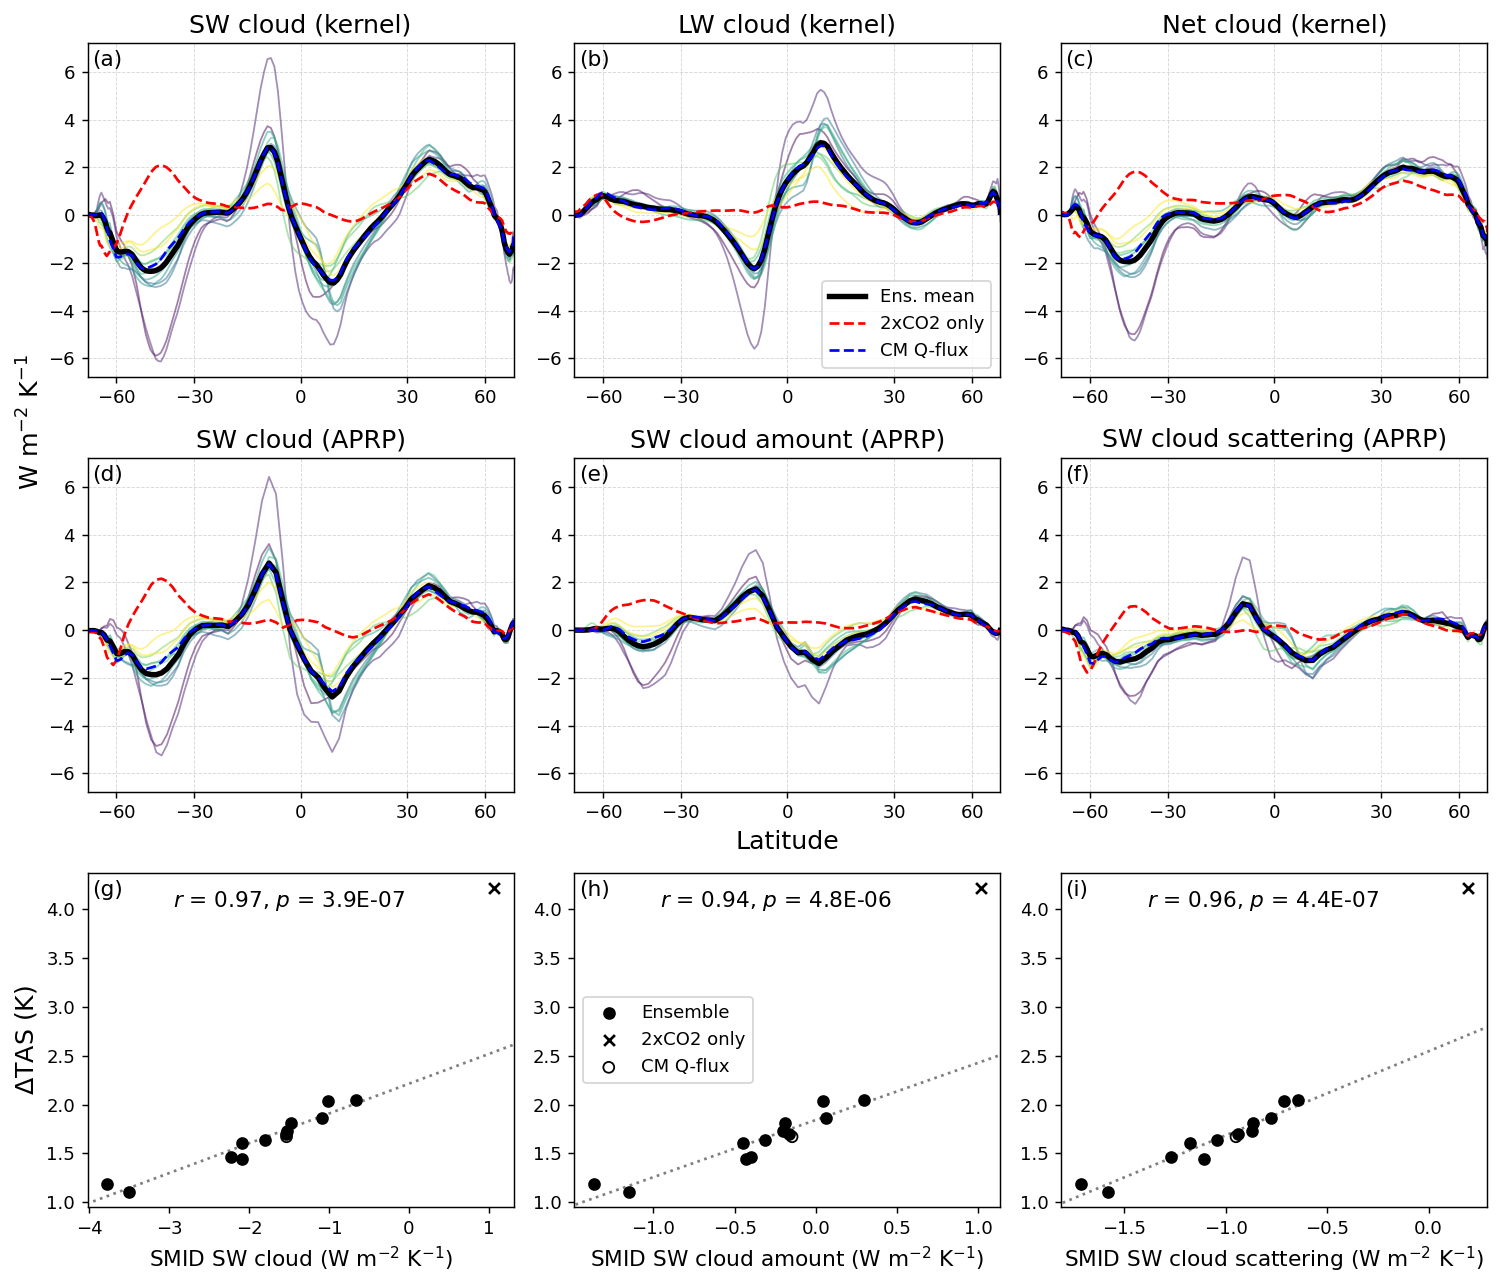

In [20]:
fig_z = plt.figure(2, dpi=130, figsize=(12, 10))

axsw = plt.subplot(331)
axlw = plt.subplot(332, sharey=axsw)
axnet = plt.subplot(333, sharey=axsw)
ax0 = plt.subplot(334, sharey=axsw)
ax1 = plt.subplot(335, sharey=axsw)
ax2 = plt.subplot(336, sharey=axsw)
axs1 = plt.subplot(337)
axs2 = plt.subplot(338, sharey=axs1)
axs3 = plt.subplot(339, sharey=axs1)

for j, m in enumerate(aprp_ens.model):
    axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.sel(model=m).mean(dim='lon'), 
              color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5, linewidth=1)
    axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model=m).mean(dim='lon'), 
              color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5, linewidth=1)
    axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.sel(model=m).mean(dim='lon'), 
              color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5, linewidth=1)
    
    ax0.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld.sel(model=m).mean(dim='lon')/(tcr.sel(model=m)), 
             color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5, linewidth=1)
    ax1.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_amt.sel(model=m).mean(dim='lon')/(tcr.sel(model=m)), 
             color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5, linewidth=1)
    ax2.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_sca.sel(model=m).mean(dim='lon')/(tcr.sel(model=m)), 
             color=plt.cm.viridis(((gmst-gmst.min())/(gmst-gmst.min()).max()).sel(model=m)), alpha=0.5, linewidth=1)

axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.mean(dim=['lon', 'model']), color='k', linewidth=3)
axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.mean(dim=['lon', 'model']), color='k', linewidth=3, label='Ens. mean')
axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.mean(dim=['lon', 'model']), color='k', linewidth=3)
ax0.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld.mean(dim=['lon', 'model'])/tcr.mean(dim='model'), color='k', linewidth=3)
ax1.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_amt.mean(dim=['lon', 'model'])/tcr.mean(dim='model'), color='k', linewidth=3)
ax2.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_sca.mean(dim=['lon', 'model'])/tcr.mean(dim='model'), color='k', linewidth=3)

axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.sel(model='2xCO2-only').mean(dim=['lon']), color='r', linestyle='--')
axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model='2xCO2-only').mean(dim=['lon']), color='r', linestyle='--', label='2xCO2 only')
axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.sel(model='2xCO2-only').mean(dim=['lon']), color='r', linestyle='--')
ax0.plot(np.sin(np.deg2rad(aprp_co2.lat)), aprp_co2.cld.mean(dim='lon')/ecs, color='r', linestyle='--')
ax1.plot(np.sin(np.deg2rad(aprp_co2.lat)), aprp_co2.cld_amt.mean(dim='lon')/ecs, color='r', linestyle='--')
ax2.plot(np.sin(np.deg2rad(aprp_co2.lat)), aprp_co2.cld_sca.mean(dim='lon')/ecs, color='r', linestyle='--')

axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.sel(model='CMIP5-EM').mean(dim=['lon']), color='b', linestyle='--')
axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model='CMIP5-EM').mean(dim=['lon']), color='b', linestyle='--', label='CM Q-flux')
axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.sel(model='CMIP5-EM').mean(dim=['lon']), color='b', linestyle='--')
ax0.plot(np.sin(np.deg2rad(aprp_cm.lat)), aprp_cm.cld.mean(dim='lon')/tcr_cm, color='b', linestyle='--')
ax1.plot(np.sin(np.deg2rad(aprp_cm.lat)), aprp_cm.cld_amt.mean(dim='lon')/tcr_cm, color='b', linestyle='--')
ax2.plot(np.sin(np.deg2rad(aprp_cm.lat)), aprp_cm.cld_sca.mean(dim='lon')/tcr_cm, color='b', linestyle='--')

for model in ens12_smid_fbs.model:
    if model == 'BNU-ESM':
        axs1.scatter(ens12_smid_fbs.SW_cloud.sel(model=model), tcr.sel(model=model), color='k', label='Ensemble')
    else:
        axs1.scatter(ens12_smid_fbs.SW_cloud.sel(model=model), tcr.sel(model=model), color='k')

axs1.scatter(smid_fbs.sel(model='2xCO2-only').SW_cloud, ecs, color='k', marker='x', label='2xCO2 only')
axs1.scatter(smid_fbs.sel(model='CMIP5-EM').SW_cloud, tcr_cm, edgecolor='k', facecolor='none', label='CM Q-flux')
plot_trend(axs1, ens12_smid_fbs.SW_cloud, ens12_smid_fbs.TCR)
axs1.set_ylabel('$\Delta$TAS (K)', fontsize=14)
axs1.set_xlabel('SMID SW cloud (W m$^{-2}$ K$^{-1}$)', fontsize=12)

for model in ens12_smid_fbs.model:
    if model == 'BNU-ESM':
        axs2.scatter(smid_aprp_ens.cld_amt.sel(model=model)/tcr.sel(model=model), tcr.sel(model=model), color='k', label='Ensemble')
    else:
        axs2.scatter(smid_aprp_ens.cld_amt.sel(model=model)/tcr.sel(model=model), tcr.sel(model=model), color='k')

axs2.scatter(smid_aprp_co2.cld_amt/ecs, ecs, color='k', marker='x', label='2xCO2 only')
axs2.scatter(smid_aprp_cm.cld_amt/tcr_cm, tcr_cm, edgecolor='k', facecolor='none', label='CM Q-flux')
plot_trend(axs2, smid_aprp_ens.cld_amt/tcr, tcr)
axs2.set_xlabel('SMID SW cloud amount (W m$^{-2}$ K$^{-1}$)', fontsize=12)

for model in ens12_smid_fbs.model:
    if model == 'BNU-ESM':
        axs3.scatter(smid_aprp_ens.cld_sca.sel(model=model)/tcr.sel(model=model), tcr.sel(model=model), color='k', label='Ensemble')
    else:
        axs3.scatter(smid_aprp_ens.cld_sca.sel(model=model)/tcr.sel(model=model), tcr.sel(model=model), color='k')

axs3.scatter(smid_aprp_co2.cld_sca/ecs, ecs, color='k', marker='x', label='2xCO2 only')
axs3.scatter(smid_aprp_cm.cld_sca/tcr_cm, tcr_cm, edgecolor='k', facecolor='none', label='CM Q-flux')
plot_trend(axs3, smid_aprp_ens.cld_sca/tcr, tcr)
axs3.set_xlabel('SMID SW cloud scattering (W m$^{-2}$ K$^{-1}$)', fontsize=12)

xtd = [-60, -30, 0, 30, 60]
axsw.set_xlim(-1, 1)
axsw.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
axlw.set_xlim(-1, 1)
axlw.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
axnet.set_xlim(-1, 1)
axnet.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
ax0.set_xlim(-1, 1)
ax0.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
ax1.set_xlim(-1, 1)
ax1.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
ax2.set_xlim(-1, 1)
ax2.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])

axsw.grid(alpha=0.5, linestyle='--', linewidth=0.5)
axlw.grid(alpha=0.5, linestyle='--', linewidth=0.5)
axnet.grid(alpha=0.5, linestyle='--', linewidth=0.5)
ax0.grid(alpha=0.5, linestyle='--', linewidth=0.5)
ax1.grid(alpha=0.5, linestyle='--', linewidth=0.5)
ax2.grid(alpha=0.5, linestyle='--', linewidth=0.5)

axsw.set_title('SW cloud (kernel)', fontsize=14)
axlw.set_title('LW cloud (kernel)', fontsize=14)
axnet.set_title('Net cloud (kernel)', fontsize=14)
ax0.set_title('SW cloud (APRP)', fontsize=14)
ax1.set_title('SW cloud amount (APRP)', fontsize=14)
ax2.set_title('SW cloud scattering (APRP)', fontsize=14)

axsw.text(.01, .98, '(a)', ha='left', va='top', fontsize=12, transform=axsw.transAxes)
axlw.text(.01, .98, '(b)', ha='left', va='top', fontsize=12, transform=axlw.transAxes)
axnet.text(.01, .98, '(c)', ha='left', va='top', fontsize=12, transform=axnet.transAxes)
ax0.text(.01, .98, '(d)', ha='left', va='top', fontsize=12, transform=ax0.transAxes)
ax1.text(.01, .98, '(e)', ha='left', va='top', fontsize=12, transform=ax1.transAxes)
ax2.text(.01, .98, '(f)', ha='left', va='top', fontsize=12, transform=ax2.transAxes)
axs1.text(.01, .98, '(g)', ha='left', va='top', fontsize=12, transform=axs1.transAxes)
axs2.text(.01, .98, '(h)', ha='left', va='top', fontsize=12, transform=axs2.transAxes)
axs3.text(.01, .98, '(i)', ha='left', va='top', fontsize=12, transform=axs3.transAxes)

smid_pcc_tot, smid_p_tot = pearsonr(ens12_smid_fbs.SW_cloud.sortby(tcr), tcr)[0:2]
smid_pcc_amt, smid_p_amt = pearsonr(smid_aprp_ens.cld_amt/tcr, tcr)[0:2]
smid_pcc_sca, smid_p_sca = pearsonr(smid_aprp_ens.cld_sca/tcr, tcr)[0:2]
axs1.text(.2, .9, s='$r$ = %.2f, $p$ = %.1E' %(smid_pcc_tot, smid_p_tot), transform=axs1.transAxes, fontsize=12)
axs2.text(.2, .9, s='$r$ = %.2f, $p$ = %.1E' %(smid_pcc_amt, smid_p_amt), transform=axs2.transAxes, fontsize=12)
axs3.text(.2, .9, s='$r$ = %.2f, $p$ = %.1E' %(smid_pcc_sca, smid_p_sca), transform=axs3.transAxes, fontsize=12)

fig_z.supylabel('W m$^{-2}$ K$^{-1}$', fontsize=14, y=0.67, x=0.045)
ax1.set_xlabel('Latitude', y=-0.0, fontsize=14)
axlw.legend(loc='lower right')
axs2.legend(loc='center left')
plt.tight_layout()

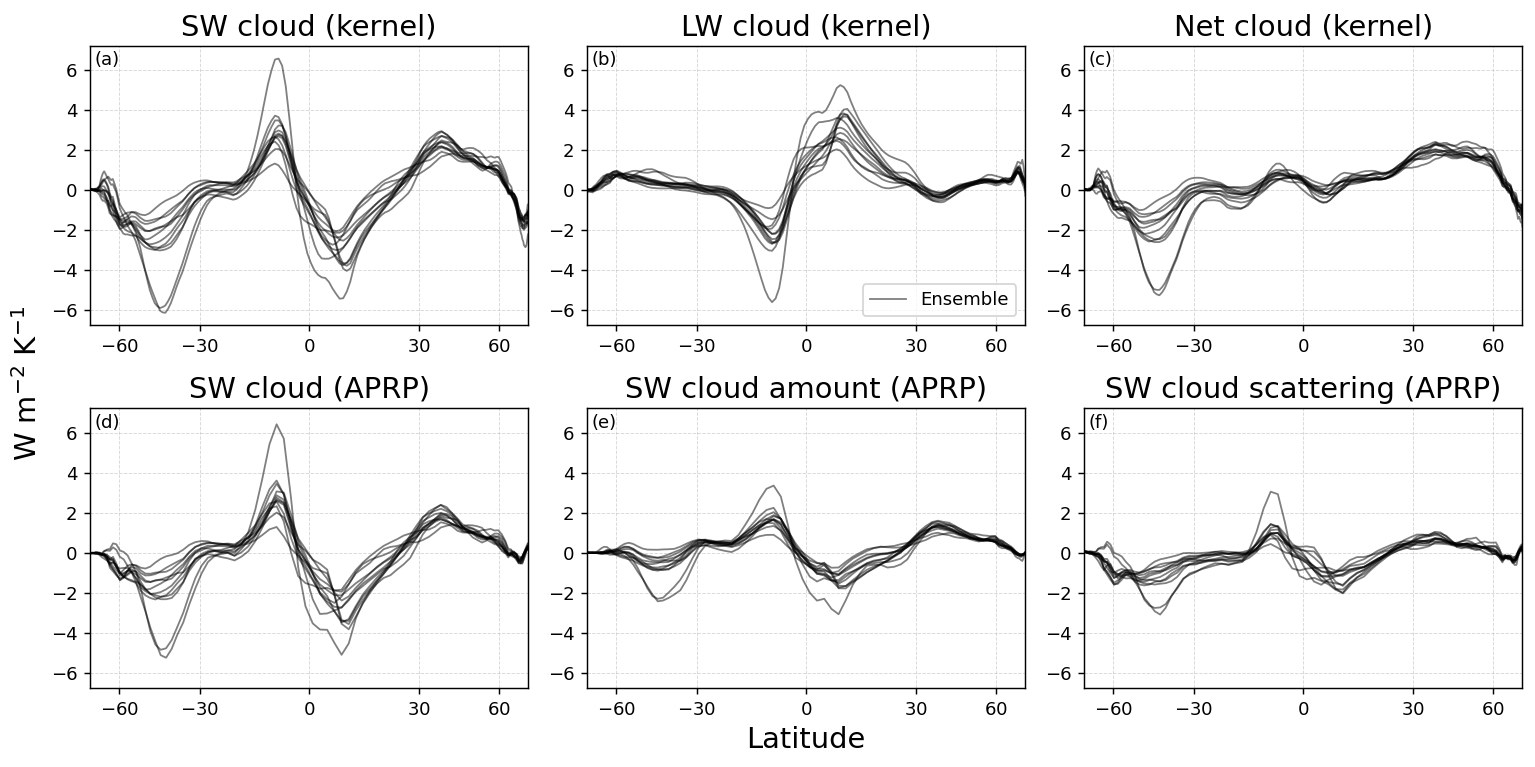

In [21]:
fig_z = plt.figure(2, dpi=130, figsize=(12, 6))

axsw = plt.subplot(231)
axlw = plt.subplot(232, sharey=axsw)
axnet = plt.subplot(233, sharey=axsw)
ax0 = plt.subplot(234, sharey=axsw)
ax1 = plt.subplot(235, sharey=axsw)
ax2 = plt.subplot(236, sharey=axsw)

for j, m in enumerate(aprp_ens.model):
    axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.sel(model=m).mean(dim='lon'), 
              color='k', alpha=0.5, linewidth=1)
    if j == 0:
        axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model=m).mean(dim='lon'), 
                  color='k', alpha=0.5, linewidth=1, label='Ensemble')
    else:
        axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model=m).mean(dim='lon'), 
                  color='k', alpha=0.5, linewidth=1)
        
    axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.sel(model=m).mean(dim='lon'), 
              color='k', alpha=0.5, linewidth=1)
    
    ax0.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld.sel(model=m).mean(dim='lon')/(tcr.sel(model=m)), 
             color='k', alpha=0.5, linewidth=1)
    ax1.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_amt.sel(model=m).mean(dim='lon')/(tcr.sel(model=m)), 
             color='k', alpha=0.5, linewidth=1)
    ax2.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_sca.sel(model=m).mean(dim='lon')/(tcr.sel(model=m)), 
             color='k', alpha=0.5, linewidth=1)

# axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.mean(dim=['lon', 'model']), color='k', linewidth=3)
# axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.mean(dim=['lon', 'model']), color='k', linewidth=3, label='Ens. mean')
# axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.mean(dim=['lon', 'model']), color='k', linewidth=3)
# ax0.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld.mean(dim=['lon', 'model'])/tcr.mean(dim='model'), color='k', linewidth=3)
# ax1.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_amt.mean(dim=['lon', 'model'])/tcr.mean(dim='model'), color='k', linewidth=3)
# ax2.plot(np.sin(np.deg2rad(aprp_ens.lat)), aprp_ens.cld_sca.mean(dim=['lon', 'model'])/tcr.mean(dim='model'), color='k', linewidth=3)

# axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.sel(model='2xCO2-only').mean(dim=['lon']), color='r', linestyle='--')
# axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model='2xCO2-only').mean(dim=['lon']), color='r', linestyle='--', label='2xCO2 only')
# axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.sel(model='2xCO2-only').mean(dim=['lon']), color='r', linestyle='--')
# ax0.plot(np.sin(np.deg2rad(aprp_co2.lat)), aprp_co2.cld.mean(dim='lon')/ecs, color='r', linestyle='--')
# ax1.plot(np.sin(np.deg2rad(aprp_co2.lat)), aprp_co2.cld_amt.mean(dim='lon')/ecs, color='r', linestyle='--')
# ax2.plot(np.sin(np.deg2rad(aprp_co2.lat)), aprp_co2.cld_sca.mean(dim='lon')/ecs, color='r', linestyle='--')

# axsw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.SW_cloud.sel(model='CMIP5-EM').mean(dim=['lon']), color='b', linestyle='--')
# axlw.plot(np.sin(np.deg2rad(fbs.lat)), fbs.LW_cloud.sel(model='CMIP5-EM').mean(dim=['lon']), color='b', linestyle='--', label='CM Q-flux')
# axnet.plot(np.sin(np.deg2rad(fbs.lat)), fbs.Net_cloud.sel(model='CMIP5-EM').mean(dim=['lon']), color='b', linestyle='--')
# ax0.plot(np.sin(np.deg2rad(aprp_cm.lat)), aprp_cm.cld.mean(dim='lon')/tcr_cm, color='b', linestyle='--')
# ax1.plot(np.sin(np.deg2rad(aprp_cm.lat)), aprp_cm.cld_amt.mean(dim='lon')/tcr_cm, color='b', linestyle='--')
# ax2.plot(np.sin(np.deg2rad(aprp_cm.lat)), aprp_cm.cld_sca.mean(dim='lon')/tcr_cm, color='b', linestyle='--')

xtd = [-60, -30, 0, 30, 60]
axsw.set_xlim(-1, 1)
axsw.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
axlw.set_xlim(-1, 1)
axlw.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
axnet.set_xlim(-1, 1)
axnet.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
ax0.set_xlim(-1, 1)
ax0.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
ax1.set_xlim(-1, 1)
ax1.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])
ax2.set_xlim(-1, 1)
ax2.set_xticks(ticks=np.sin(np.deg2rad(xtd)), labels=['$-60$', '$-30$', '$0$', '$30$', '$60$'])

axsw.grid(alpha=0.5, linestyle='--', linewidth=0.5)
axlw.grid(alpha=0.5, linestyle='--', linewidth=0.5)
axnet.grid(alpha=0.5, linestyle='--', linewidth=0.5)
ax0.grid(alpha=0.5, linestyle='--', linewidth=0.5)
ax1.grid(alpha=0.5, linestyle='--', linewidth=0.5)
ax2.grid(alpha=0.5, linestyle='--', linewidth=0.5)

axsw.set_title('SW cloud (kernel)', fontsize=16)
axlw.set_title('LW cloud (kernel)', fontsize=16)
axnet.set_title('Net cloud (kernel)', fontsize=16)
ax0.set_title('SW cloud (APRP)', fontsize=16)
ax1.set_title('SW cloud amount (APRP)', fontsize=16)
ax2.set_title('SW cloud scattering (APRP)', fontsize=16)

axsw.text(.01, .98, '(a)', ha='left', va='top', transform=axsw.transAxes)
axlw.text(.01, .98, '(b)', ha='left', va='top', transform=axlw.transAxes)
axnet.text(.01, .98, '(c)', ha='left', va='top', transform=axnet.transAxes)
ax0.text(.01, .98, '(d)', ha='left', va='top', transform=ax0.transAxes)
ax1.text(.01, .98, '(e)', ha='left', va='top', transform=ax1.transAxes)
ax2.text(.01, .98, '(f)', ha='left', va='top', transform=ax2.transAxes)

fig_z.supylabel('W m$^{-2}$ K$^{-1}$', fontsize=16)
ax1.set_xlabel('Latitude', y=-0.0, fontsize=16)

#plt.suptitle('Zonal-mean cloud feedbacks', y=1.0, fontsize=16)
axlw.legend(loc='lower right')
plt.tight_layout()

## Correlations between all feedbacks and TCR

In [22]:
for feedback in copy_ens12_gm_fbs.data_vars:
    print(feedback+': r = %.2f, p = %.2e' %pearsonr(copy_ens12_gm_fbs[feedback], copy_ens12_gm_fbs.TCR))

Total: r = 0.94, p = 6.02e-06
Planck: r = 0.17, p = 6.04e-01
LR: r = 0.90, p = 7.26e-05
Net_T: r = 0.87, p = 2.80e-04
SW_q: r = -0.66, p = 1.86e-02
LW_q: r = -0.74, p = 5.49e-03
Net_q: r = -0.75, p = 5.17e-03
SW_cloud: r = 0.95, p = 2.44e-06
LW_cloud: r = -0.89, p = 1.04e-04
Net_cloud: r = 0.95, p = 1.79e-06
Albedo: r = 0.02, p = 9.46e-01
TCR: r = 1.00, p = 0.00e+00


In [23]:
for feedback in ens12_smid_fbs.data_vars:
    print(feedback+': r = %.2f, p = %.2e' %pearsonr(ens12_smid_fbs[feedback], ens12_smid_fbs.TCR))

Total: r = 0.97, p = 7.99e-08
Planck: r = -0.93, p = 1.08e-05
LR: r = 0.98, p = 4.78e-08
Net_T: r = -0.87, p = 2.68e-04
SW_q: r = 0.88, p = 1.31e-04
LW_q: r = 0.80, p = 1.69e-03
Net_q: r = 0.83, p = 9.10e-04
SW_cloud: r = 0.97, p = 3.90e-07
LW_cloud: r = -0.92, p = 1.71e-05
Net_cloud: r = 0.97, p = 3.87e-07
Albedo: r = 0.73, p = 6.68e-03
TCR: r = 1.00, p = 0.00e+00
